# Cost Calculation

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from langchain.document_loaders import UnstructuredHTMLLoader, UnstructuredPDFLoader
from langchain.chat_models import ChatOpenAI
from langchain_community.embeddings import OpenAIEmbeddings
from functools import partial
from langchain.prompts import PromptTemplate
from langchain_core.prompts import format_document

## API Costs LLM

**LLM**: gpt-3.5-turbo-0125

*Note: We are using gpt-3.5-turbo-0613 at the moment. The API will change to gpt-3.5-turbo-0125 automatically on February 16th 2024.*

- **context window**: 16,385 tokens
- **input cost**: 0.0005$ / 1k tokens
- **output cost**: 0.0015$ / 1k tokens

sources: 

- https://platform.openai.com/docs/models/gpt-3-5-turbo
- https://openai.com/pricing


## API Costs Embeddings

**Embedding model**: text-embedding-ada-002

> Most capable 2nd generation embedding model, replacing 16 first generation models

- **input cost**: 0.0001$ / 1k tokens

**Alternative embedding model**: text-embedding-3-small

*Note: We are using text-embedding-ada-002 at the moment. We should switch to text-embedding-3-small. This model creates embeddings of the same size, costs 1/5 of the ada model and seems to have a better performance.*

> Increased performance over 2nd generation ada embedding model

- **input cost**: 0.00002$ / 1k tokens

sources: 

- https://platform.openai.com/docs/models/embeddings
- https://openai.com/pricing


## What number of tokens do our documents have?

The following code visualizes the length of our documents in terms of tokens. This is important with consideration to the token input limit of the LLM we are using. 

In [2]:
# get a list of all scraped files
base_path = "data/scraped_data/"
docs_list = os.listdir(base_path)

# get separate lists of PDF and HTML files
htmls = [d for d in docs_list if d.split(".")[-1] == "html"]
pdfs = [d for d in docs_list if d.split(".")[-1] == "pdf"]
n_docs_total = len(docs_list)
n_htmls = len(htmls)
n_pdfs = len(pdfs)

print(f"number of HTMLs: {n_htmls}")
print(f"number of PDFs: {n_pdfs}")

number of HTMLs: 111
number of PDFs: 161


In [3]:
# if sample is set as true a sample of the files is used for the following calculations
# otherwise the whole dataset is used
sample = False
if sample:
    np.random.seed(0)
    sample_size_htmls = 50
    sample_size_pdfs = 50
    htmls_sample = np.random.choice(htmls, 50, replace=False)
    pdfs_sample = np.random.choice(pdfs, 50, replace=False)
else:
    htmls_sample = htmls
    pdfs_sample = pdfs
print(f"number of sampled HTMLs: {len(htmls_sample)}")
print(f"number of sampled PDFs: {len(pdfs_sample)}")

# load files as langchain document objects
html_documents = []
for file in htmls_sample:
    loader = UnstructuredHTMLLoader(base_path + file)
    html_documents.extend(loader.load())
pdf_documents = []
for file in pdfs_sample:
    loader = UnstructuredPDFLoader(base_path + file)
    pdf_documents.extend(loader.load())

number of sampled HTMLs: 111
number of sampled PDFs: 161


In [4]:
# prompt and method for converting document to str
document_prompt = PromptTemplate.from_template("{page_content}")
partial_format_document = partial(format_document, prompt=document_prompt)

# get token counts for documents in samples
llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo-0125")
def get_num_tokens_single_doc(doc):
    return llm.get_num_tokens(partial_format_document(doc))

html_token_counts = np.array([])
for i, doc in enumerate(html_documents):
    n_tokens = get_num_tokens_single_doc(doc)
    html_token_counts = np.append(html_token_counts, n_tokens)
pdf_token_counts = np.array([])
for i, doc in enumerate(pdf_documents):
    n_tokens = get_num_tokens_single_doc(doc)
    pdf_token_counts = np.append(pdf_token_counts, n_tokens)

/home/felix/anaconda3/envs/chatbot/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:115: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use langchain_openai.ChatOpenAI instead.
  warn_deprecated(


In [5]:
llm_max_tokens = 16385

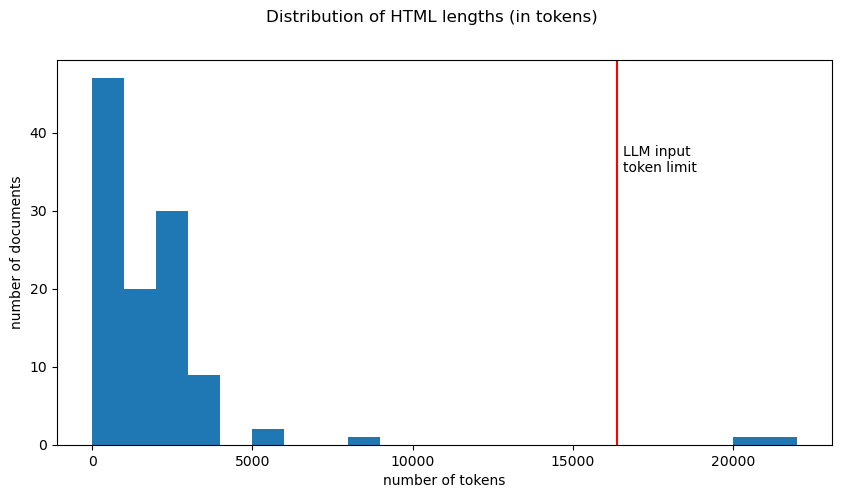

In [6]:
# plot distribution of token counts in HTMLs

longest_html = int(max(html_token_counts))

fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(html_token_counts, bins=range(0, longest_html + 1000, 1000))
ax.set_ylim(ax.get_ylim())
ax.vlines([llm_max_tokens], 0, ax.get_ylim()[1], color="red") 
ax.set_xlabel("number of tokens")
ax.set_ylabel("number of documents")
plt.suptitle("Distribution of HTML lengths (in tokens)")
ax.annotate("LLM input\ntoken limit", xy=(llm_max_tokens + 200, 35))

plt.show()

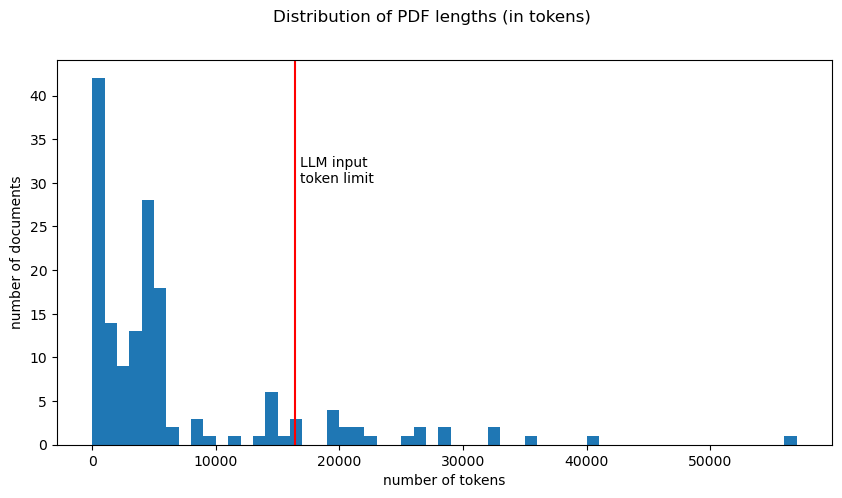

In [7]:
# plot distribution of token counts in HTMLs

longest_pdf = int(max(pdf_token_counts))

fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(pdf_token_counts, bins=range(0, longest_pdf + 1000, 1000))
ax.set_ylim(ax.get_ylim())
ax.vlines([llm_max_tokens], 0, ax.get_ylim()[1], color="red") 
ax.set_xlabel("number of tokens")
ax.set_ylabel("number of documents")
plt.suptitle("Distribution of PDF lengths (in tokens)")
ax.annotate("LLM input\ntoken limit", xy=(llm_max_tokens + 400, 30))

plt.show()

In [8]:
# Calculate the number of documents that can be processed by the LLM without prior document summarization.
# The number of tokens in the document + the number of tokens for instructions in the prompt needs to be
# smaller than the maximum number of tokens the model can process.

# aproximate tokens buffer for prompt instructions
tokens_prompt_inst = 200

html_over_limit = html_token_counts > (llm_max_tokens + tokens_prompt_inst)
html_over_limit_proportion = round(100 * sum(html_over_limit / len(html_token_counts)), 2)
print(f"number of HTMLs that don't fit the token limit: {sum(html_over_limit)} ({html_over_limit_proportion}%)")

pdf_over_limit = pdf_token_counts > (llm_max_tokens + tokens_prompt_inst)
pdf_over_limit_proportion = round(100 * sum(pdf_over_limit / len(pdf_token_counts)), 2)
print(f"number of PDFs that don't fit the token limit: {sum(pdf_over_limit)} ({pdf_over_limit_proportion}%)")

number of HTMLs that don't fit the token limit: 2 (1.8%)
number of PDFs that don't fit the token limit: 19 (11.8%)


Most documents fit the maximum token input restriction of the GPT-3.5-turbo-0125 model.

## Metadata Cost Calculation

The following code cells calculate an estimation of the cost for creating metadata. The calculation disregards the fact that some documents are too long to fit the token input limit of the model we are using. While there are not a lot of documents that have to summarized for that reason, it would add more cost if we are using an OpenAI LLM for that.

In [9]:
metadata_example = """study_program: M.Sc. Business Informatics
short_description: Information about the requirements and procedure for writing a master's thesis in the M.Sc. Business Informatics program at the University of Mannheim."""
llm.get_num_tokens(metadata_example)

41

In [10]:
# costs for generating metadata (simplified without considering document summarization)
# input cost
dollar_per_token_llm_input = 0.0005
html_metadata_input_cost = (html_token_counts * dollar_per_token_llm_input).sum()
pdf_metadata_input_cost = (pdf_token_counts * dollar_per_token_llm_input).sum()
total_metadata_input_cost = html_metadata_input_cost + pdf_metadata_input_cost
# output cost
dollar_per_token_llm_output = 0.0015
avg_metadata_tokens = 50
html_metadata_output_cost = len(html_token_counts) * avg_metadata_tokens * dollar_per_token_llm_output
pdf_metadata_output_cost = len(pdf_token_counts) * avg_metadata_tokens * dollar_per_token_llm_output
total_metadata_output_cost = html_metadata_output_cost + pdf_metadata_output_cost
# total cost
total_metadata_cost = total_metadata_input_cost + total_metadata_output_cost

if sample == True:
    print("Note: The costs are calculated for a sample only.")
print("input cost:")
print(f"\tinput cost for generating meatadata for the HTMLs: {round(html_metadata_input_cost, 2)}$")
print(f"\tinput cost for generating metadata for the PDFs: {round(pdf_metadata_input_cost, 2)}$")
print(f"\ttotal input cost: {round(total_metadata_input_cost, 2)}$")
print("output cost:")
print(f"\toutput cost for generating meatadata for the HTMLs: {round(html_metadata_output_cost, 2)}$")
print(f"\toutput cost for generating metadata for the PDFs: {round(pdf_metadata_output_cost, 2)}$")
print(f"\ttotal output cost: {round(total_metadata_output_cost, 2)}$")
print("total cost:")
print(f"\ttotal cost of metadata generation: {round(total_metadata_cost, 2)}$")

input cost:
	input cost for generating meatadata for the HTMLs: 110.16$
	input cost for generating metadata for the PDFs: 538.69$
	total input cost: 648.85$
output cost:
	output cost for generating meatadata for the HTMLs: 8.32$
	output cost for generating metadata for the PDFs: 12.08$
	total output cost: 20.4$
total cost:
	total cost of metadata generation: 669.25$


We have to cut the costs if we want to generate metadata with OpenAI. The output cost is fixed, as it only depends on the number of documents and the amount of tokens in the metadata.

- We can try to summarize **all** documents, even if they fit the token limit. We would have to significantly reduce the length of the documents to make the cost feasable.
- Another option would be to only generate metadata for a selection of documents. But then we would have to make reasonable selection.

## Embedding Cost Calculation

The following code estimates the cost for creating embeddings.

In [11]:
# costs for calculating embeddings
dollar_per_token_emb = 0.00002
html_embedding_cost = (html_token_counts * dollar_per_token_emb).sum()
pdf_embedding_cost = (pdf_token_counts * dollar_per_token_emb).sum()
total_embedding_cost = html_embedding_cost + pdf_embedding_cost

if sample == True:
    print("Note: The costs are calculated for a sample only.")
print(f"cost of embedding HTMLs: {round(html_embedding_cost, 2)}$")
print(f"cost of embedding PDFs: {round(pdf_embedding_cost, 2)}$")
print(f"total cost of embedding: {round(total_embedding_cost, 2)}$")

cost of embedding HTMLs: 4.41$
cost of embedding PDFs: 21.55$
total cost of embedding: 25.95$


In comparison to the cost for creating metadata, the cost for creating embeddings is much lower. We could still consider to compute embeddings locally (on the BWCluster) instead of using the OpenAI API.